# Wasserstein Generative Adversarial Network for Time Series Generation

This notebook was developed as part of my bachelor's final thesis "Augmenting SNR Datasets through Advanced Learning Techniques". Motivations and ground-truth data obtaintion methods are explained in the document.



In this notebook it is implemented in PyTorch a WGAN with possibility of CNNs or LSTMs as both generator and/or discriminator.

Author: **Mario Rodríguez Ibáñez**  mario.ri39@gmail.com

In [ ]:
import tensorflow as tf
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn
import torch.nn.utils
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

# Data import

The code in this stage assumes the usage of Google Colab and Drive.

In [ ]:
#@title Select data to be used
#@markdown * Metric to be generated.
#@markdown * MGEN yraffic patterns to be used as reference for generation.
#@markdown * Transmission gain pattern. (For generating SNR series, good results are only obtained when using "Fixed").
#@markdown * Transmission gain level. (For generating SNR series, good results are only obtained when using individual levels).

# Metric selection
metric = "All" #@param ["SNR", "Decoding time", "BSR", "All"]

selected_metrics = []
if metric == "All":
  selected_metrics = ["UL mean SINR", "Decoding time", "UL buffer states"]
  y_label = ["SNR (dB)", "Decoding Time (us)", "BSR (Byte)"]
elif metric == "SNR":
  selected_metrics = ["UL mean SINR"]
  y_label = ["SNR (dB)"]
elif metric == "Decoding Time":
  selected_metrics = ["Decoding time"]
  y_label = ["Decoding Time (us)"]
elif metric == "BSR":  
  selected_metrics =  ["UL buffer states"]
  y_label = ["BSR (Byte)"]

traffic_pattern = "Clone" #@param ["Poisson", "Burst", "Clone", "All"]

# MGEN patterns
patterns = []
if traffic_pattern == "All":
  patterns = ['poisson', 'burst', 'clone']
elif traffic_pattern == "Poisson":
  patterns = ["poisson"]
elif traffic_pattern == "Burst":
  patterns = ["burst"]
elif traffic_pattern == "Clone":
  patterns = ["clone"]

gain_level = "Medium" #@param ["All", "High", "Medium", "Low"]

if gain_level == "All":
  gain_level_list = ["high", "med", "low"]
elif gain_level == "High":
  gain_level_list = ["high"]
elif gain_level == "Medium":
  gain_level_list = ["med"]
elif gain_level == ["Low"]:
  gain_level_list = ["low"]

gain_pattern = "Fixed" #@param ["Fixed","Triangular waveform", "Random steps waveform", "All"]

if gain_pattern == "All":
  gain_pattern_list = ["trian", "rand", "fixed"]
elif gain_pattern == "Fixed":
  gain_pattern_list = ["fixed"]
elif gain_pattern == "Triangular waveform":
  gain_pattern_list = ["trian"]
elif gain_pattern == ["Random steps waveform"]:
  gain_pattern_list = ["rand"]

# Combinations of TX Gain levels and TX Gain patterns (for SNR generations use only fixed patterns and comment the rest) 
gain_modes = []
[gain_modes.append(gain_level+"_"+gain_pattern) 
  for gain_pattern in gain_pattern_list
  for gain_level in gain_level_list]

# Path to dataset folder
common_path = '/content/drive/My Drive/TFG/WGAN_time_series/filtered_data/' 

# Bitrates
ul_rates = ['2M', '5M', '10M']

# Videocall applications for clone pattern
video_apps = ['skype', 'hangouts']



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
src_paths = []

[src_paths.append(common_path+pattern+'_'+ul_rate+'_'+gain_mode+'.csv') 
    if pattern != "clone" 
    else 
    src_paths.append(common_path+pattern+'_'+video_app+'_'+gain_mode+'.csv')
    for pattern in patterns
    for ul_rate in ul_rates
    for video_app in video_apps
    for gain_mode in gain_modes
    ]
    
# Eliminate duplicates
src_paths = set(src_paths)

df_list = []
[df_list.append(pd.read_csv(path, sep=",", encoding="utf-8", header = 0)) for path in src_paths]

# Concatenate the selected dataframes in a single one to be used as training data
df = pd.concat(df_list)

# Select all the metric to be generated
df = df[selected_metrics]

## Data Standarization

In [ ]:
minmax_scaler = MinMaxScaler(feature_range=(0,1)).fit(df)
scaled_df = minmax_scaler.transform(df)

#Models

Based on the models in https://github.com/proceduralia/pytorch-GAN-timeseries/tree/master/models

## CNN models

In [ ]:
class Chomp1d(torch.nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(torch.nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = torch.nn.utils.weight_norm(torch.nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(dropout)

        self.conv2 = torch.nn.utils.weight_norm(torch.nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = torch.nn.ReLU()
        self.dropout2 = torch.nn.Dropout(dropout)

        self.net = torch.nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = torch.nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = torch.nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(torch.nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
 
        self.network = torch.nn.Sequential(*layers)

    def  forward(self, x):
        return self.network(x)


class TCN(torch.nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = torch.nn.Linear(num_channels[-1], output_size)
        self.init_weights()

    def init_weights(self):
          self.linear.weight.data.normal_(0, 0.01)
    
    def forward(self, x, channel_last=True):
        #If channel_last, the expected format is (batch_size, seq_len, features)
        y1 = self.tcn(x.transpose(1, 2) if channel_last else x)
        return self.linear(y1.transpose(1, 2))


class CausalConvDiscriminator(torch.nn.Module):
    """Discriminator using casual dilated convolution, outputs a probability for each time step
    Args:
        input_size (int): dimensionality (channels) of the input
        n_layers (int): number of hidden layers
        n_channels (int): number of channels in the hidden layers (it's always the same)
        kernel_size (int): kernel size in all the layers
        dropout: (float in [0-1]): dropout rate
        
    Input: (batch_size, seq_len, input_size)
    Output: (batch_size, seq_len, 1)
    """
    def __init__(self, input_size, n_layers, n_channel, kernel_size, dropout=0):
        super().__init__()
        #Assuming same number of channels layerwise
        num_channels = [n_channel] * n_layers
        self.tcn = TCN(input_size, 1, num_channels, kernel_size, dropout)
        
    def forward(self, x, channel_last=True):
        return  torch.sigmoid(self.tcn(x, channel_last)) # self.tcn(x, channel_last)#

class CausalConvGenerator(torch.nn.Module):
    """Generator using casual dilated convolution, expecting a noise vector for each timestep as input
    Args:
        noise_size (int): dimensionality (channels) of the input noise
        output_size (int): dimenstionality (channels) of the output sequence
        n_layers (int): number of hidden layers
        n_channels (int): number of channels in the hidden layers (it's always the same)
        kernel_size (int): kernel size in all the layers
        dropout: (float in [0-1]): dropout rate
        
    Input: (batch_size, seq_len, input_size)
    Output: (batch_size, seq_len, outputsize)
    """ 
    def __init__(self, noise_size, output_size, n_layers, n_channel, kernel_size, dropout=0):
        super().__init__()
        num_channels = [n_channel] * n_layers
        self.tcn = TCN(noise_size, output_size, num_channels, kernel_size, dropout)
        
    def forward(self, x, channel_last=True):
        return self.tcn(x,channel_last) # torch.tanh(self.tcn(x, channel_last))#


## LSTM Models
Currently not working on GPU

In [ ]:
class LSTMGenerator(torch.nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.
    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """

    def __init__(self, in_dim, out_dim, n_layers=1, hidden_dim=256):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        self.lstm = torch.nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)
        self.linear = torch.nn.Sequential(torch.nn.Linear(hidden_dim, out_dim), torch.nn.ReLU())#, torch.nn.Tanh())#, torch.linear(hidden_dim, out_dim))

    def forward(self, input):
        batch_size, seq_len = input.size(0), input.size(1)
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim)

        recurrent_features, _ = self.lstm(input, (h_0, c_0))
        outputs = self.linear(recurrent_features.contiguous().view(batch_size*seq_len, self.hidden_dim))
        outputs = outputs.view(batch_size, seq_len, self.out_dim)
        return outputs


class LSTMDiscriminator(torch.nn.Module):
    """An LSTM based discriminator. It expects a sequence as input and outputs a probability for each element. 
    Args:
        in_dim: Input noise dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Inputs: sequence of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, 1)
    """

    def __init__(self, in_dim, n_layers=1, hidden_dim=256):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.lstm = torch.nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)
        self.linear = torch.nn.Sequential(torch.nn.Linear(hidden_dim, 1), torch.nn.Sigmoid())

    def forward(self, input):
        batch_size, seq_len = input.size(0), input.size(1)
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim)

        recurrent_features, _ = self.lstm(input, (h_0, c_0))
        outputs = self.linear(recurrent_features.contiguous().view(batch_size*seq_len, self.hidden_dim))
        outputs = outputs.view(batch_size, seq_len, 1)
        return outputs

# Data load



In [ ]:
class Df_to_dataset(Dataset):
  def __init__(self, dataframe):
    
    self.data_set = torch.FloatTensor(dataframe.astype('float'))
    #self.transform = transforms.Compose([transforms.ToTensor()]) 

  def __len__(self):
    return len(self.data_set) 

  def __getitem__(self, index):

    return self.data_set[index]

train_dataset = Df_to_dataset(scaled_df)
print(len(train_dataset))
batch_size = 200 

device_D = "cuda" if torch.cuda.is_available() else "cpu"
device_G = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': -1, 'pin_memory': True} if device_D=='cuda' else {}

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)

4211


In [ ]:
X_dim = df.shape[1] 
z_dim = df.shape[1] 
h_dim = 20 # kernel size

lr = 1e-4 # Learning rate

# Set models

In [ ]:
G = CausalConvGenerator(noise_size=z_dim, output_size=X_dim, n_layers=8, n_channel=10, kernel_size=h_dim, dropout=0.2).to(device_G)
D = CausalConvDiscriminator(input_size=X_dim, n_layers=8, n_channel=10, kernel_size=h_dim, dropout=0).to(device_D)

######################################
# LSTM not currently working in GPU ##
######################################

#device_D = 'cpu'
#train_loader.num_workers = 0
#device_G = 'cpu'
#G = LSTMGenerator(z_dim, X_dim,hidden_dim =256).to(device_G)
#D = LSTMDiscriminator(X_dim, hidden_dim =256).to(device_D)

def reset_grad():
    G.zero_grad()
    D.zero_grad()

Generator and Discriminator Optimizers

In [ ]:
G_optim = optim.RMSprop(G.parameters(), lr=lr)
D_optim = optim.RMSprop(D.parameters(), lr=lr) 

# Training


Reference chunk of the time series to generate

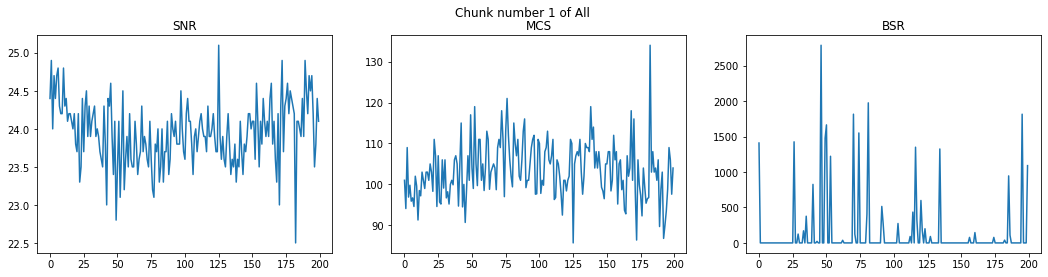

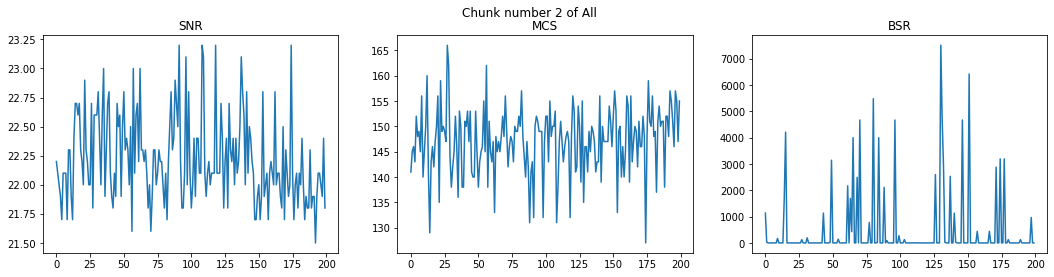

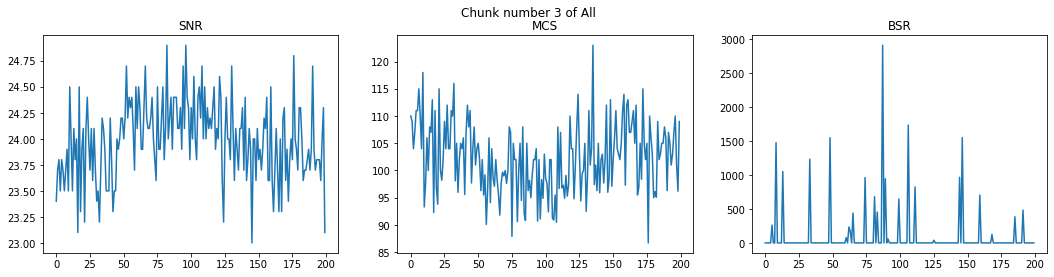

In [ ]:
plot_num = 3 # Number of chunks to be plotted
if X_dim > 1:
  titles = ["SNR", "MCS", "BSR"]

for i in range(plot_num): 
  random_chunk = random.randint(10, len(train_dataset)-batch_size)
  if X_dim == 1:
    plt.plot(minmax_scaler.inverse_transform(train_dataset.data_set.numpy())[random_chunk:random_chunk+batch_size])
    plt.title("Chunk number " + str(i+1) + " of " + metric)
    plt.show()
  else:
    fig, axs = plt.subplots(1,X_dim)
    fig.set_size_inches(18, 4)
    title = "Chunk number "+ str(i+1) + " of "+ metric
    fig.suptitle(title)
    for j in range(X_dim):
      axs[j].plot(minmax_scaler.inverse_transform(train_dataset.data_set.numpy())[random_chunk:random_chunk+batch_size, j])
      axs[j].set_title(titles[j])

In [ ]:
# Wasserstein parameters
clip_parameter = 0.02
n_crit = 5
clip_adjustment = 0
epochs = 150
num_iter = epochs * len(train_loader)
z_len = 1

# Allocate memory in device
input = torch.FloatTensor(1, batch_size,  X_dim).to(device_D)
noise = torch.FloatTensor(z_len, batch_size,  z_dim).to(device_G)
fixed_noise = torch.FloatTensor(z_len, batch_size, z_dim).normal_(0, 1).to(device_G)
fake_input = torch.FloatTensor(1, batch_size, X_dim).to(device_D)

last_iter = 0
#########################
####### TRAIN ###########
#########################
for it in range(epochs): # while GAN hasn't converged
  data_iter = iter(train_loader)
  for i in range(len(data_iter)): 
    data = next(data_iter)
    for j in range(n_crit):
    ############################
    # (1) Update D network
    ###########################
      for p in D.parameters():
        p.requires_grad = True # to avoid computation

      if it != last_iter:
        clip_parameter = 0.02

      if clip_adjustment > 5:
        clip_parameter = clip_parameter + 0.005

      # Weight clipping
      for p in D.parameters():
        p.data.clamp_(-clip_parameter, clip_parameter)
      
      D.zero_grad()
      G.zero_grad()

      # REAL DATA TO TRAIN DISCRIMINATOR
      real_cpu = data
      real_cpu = real_cpu.unsqueeze(0)
       
      input.resize_as_(real_cpu).copy_(real_cpu)
      inputv = Variable(input)
      D_real = D(inputv)
      
      # SYNTH DATA
      noise.resize_(z_len,batch_size,  z_dim).normal_(0, 1)
      noisev = Variable(noise)
      G_sample = G(noisev)
      
      fake_input.resize_as_(G_sample.data).copy_(G_sample.data)
      fake_inputv = Variable(fake_input)
      
      D_fake = D(fake_inputv)

      # Dicriminator forward-loss-backward-update  
      D_loss = -(torch.mean(D_real) - torch.mean(D_fake)) - (torch.std(input) - torch.std(fake_input)) # Modified Loss function. Now includes standard deviation.
      if D_loss > -0.01:
        clip_adjustment = clip_adjustment + 1
      else:
        clip_adjustment = 0
      
      D_loss.backward()
      D_optim.step()

    for p in D.parameters():
      p.requires_grad = False # to avoid computation
    G.zero_grad()
    noise.resize_(z_len, batch_size, z_dim).normal_(0, 1)
    noisev = Variable(noise) 
           
    G_sample = G(noisev)

    D_fake = D(G_sample)
    
    G_loss = -(torch.mean(D_fake)) # + torch.std(D_fake))
    G_loss.backward()

    G_optim.step()

    #Print and plot every now and then
    if i == len(data_iter)-1:
      print('Iter-{}; D_loss: {}; G_loss: {}'
              .format(it, D_loss.cpu().data.numpy(), G_loss.cpu().data.numpy()))
      G_sample = G(fixed_noise)

      if X_dim == 1:
        plt.plot(minmax_scaler.inverse_transform(G_sample.cpu().data.numpy()[0,h_dim:,0].reshape(batch_size-h_dim, 1)))
      else:
        fig, axs = plt.subplots(1,X_dim)
        fig.set_size_inches(18, 4)
        fig.suptitle("Data generated")

        series = minmax_scaler.inverse_transform(G_sample.cpu().data.numpy()[0,h_dim:,:].reshape(batch_size-h_dim, 3))
        for i in range(X_dim):
          axs[i].plot(series[:,i])
          axs[i].set_title(titles[i])
      plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Generation check

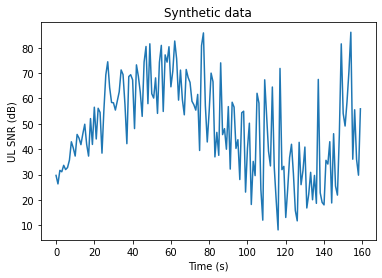

In [ ]:
gen_len = batch_size 
noise.resize_(1,gen_len,  z_dim).normal_(0, 1)
noisev = Variable(noise) 

synth_serie = minmax_scaler.inverse_transform(G(noisev).cpu().data.numpy()[0,h_dim:-h_dim,0].reshape(batch_size-2*h_dim, 1))#[0,2*batch_size:-2*batch_size,0] 
plt.title("Synthetic data")
plt.xlabel("Time (s)")
plt.ylabel("UL SNR (dB)")

plt.plot(synth_serie)
##Uncomment to save the plot in .png
#plt.savefig('/content/drive/My Drive/TFG/res/snr_h_synth.png', bbox_inches='tight')
plt.show()

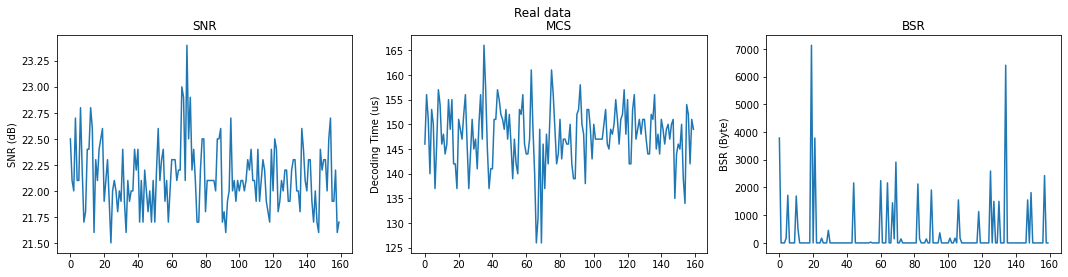

In [ ]:
gen_len = batch_size 
if X_dim > 1:
  titles = ["SNR", "MCS", "BSR"]
title = "Real data"

random_chunk = random.randint(10, len(train_dataset)-gen_len) 
if X_dim == 1:
  real_serie = minmax_scaler.inverse_transform(train_dataset.data_set.numpy())[random_chunk:random_chunk+gen_len-2*h_dim]
  plt.title(title)
  plt.xlabel("Time (s)")
  plt.ylabel(y_label[0])
  plt.plot(real_serie)
else:
  fig, axs = plt.subplots(1,X_dim)
  fig.set_size_inches(18, 4)
  fig.suptitle(title)
  real_series = minmax_scaler.inverse_transform(train_dataset.data_set.numpy())[random_chunk:random_chunk+gen_len-2*h_dim, :]
  for j in range(X_dim):
    axs[j].plot(real_series[:,j])
    axs[j].set_title(titles[j])
    axs[j].set_ylabel(y_label[j]) 
##Uncomment to save the plot in .png
#plt.savefig('/content/drive/My Drive/TFG/res/snr_h_real.png', bbox_inches='tight')
plt.show()

### Metrics


Root mean square:

In [ ]:
example_num = 100
list_synth = []
list_real = []
for i in range(example_num):
  noise.resize_(1,gen_len,  z_dim).normal_(0, 1)
  noisev = Variable(noise) 
  list_synth.append(minmax_scaler.inverse_transform(G(noisev).cpu().data.numpy())[0,h_dim:-h_dim,0])

  random_chunk = random.randint(10, len(train_dataset)-gen_len)
  list_real.append(train_dataset.data_set.numpy()[random_chunk:random_chunk+gen_len-2*h_dim])

In [ ]:
def RMS(time_serie):
  squares = []
  [squares.append(value**2) for value in time_serie]
  sum_of_squares = sum(squares)
  rms = math.sqrt(sum_of_squares/len(time_serie))
  return rms
  
real_rms = []
synth_rms = []
[real_rms.append(RMS(item)) for item in list_real]
[synth_rms.append(RMS(item)) for item in list_synth]
print("The mean RMS of the real time series is: ", sum(real_rms)/len(real_rms))
print("The mean RMS of the synthetic time series is: ", sum(synth_rms)/len(synth_rms))

The mean RMS of the real time series is:  33.71805886621175
The mean RMS of the synthetic time series is:  38.949481395300126


Peak to average ratio:

In [ ]:
def PAR(time_serie):
  peak = max(time_serie)
  return abs(peak)/RMS(time_serie)

real_par = []
synth_par = []
[real_par.append(float(PAR(item))) for item in list_real]
[synth_par.append(PAR(item)) for item in list_synth]

print("The PAR of the real time serie is: ", sum(real_par)/len(real_par))
print("The PAR of the synthetic time serie is: ",sum(synth_par)/len(synth_par) )

The PAR of the real time serie is:  1.0282553112506867
The PAR of the synthetic time serie is:  1.952520526731695


#WGAN-GP
Wasserstein Generative Adversarial Network with Gradient Penalty implementation that is not yet working: Vanishing gradient issue and crashes browser after printing in screen to many plots.

In [ ]:
G_optim = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.9))
D_optim = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.9)) # Learn faster than generator

In [ ]:
def calc_gradient_penalty(D, real_data, fake_data):
    alpha = torch.rand(real_data.size(1), 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device_D)

    interpolates = alpha * real_data + ((1 - alpha) * fake_data[:,:real_data.size(1),:])
    interpolates = interpolates.to(device_D)
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = D(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device_D),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * pen_coef
    return gradient_penalty

In [ ]:
# Wasserstein parameters
pen_coef  = 3

epochs = 100000
num_iter = epochs * len(train_loader)
z_len = 1

titles = ["SNR", "MCS", "BSR"]

# Allocate memory in device
input = torch.FloatTensor(1, batch_size,  X_dim).to(device_D)
noise = torch.FloatTensor(z_len, batch_size,  z_dim).to(device_G)
fixed_noise = torch.FloatTensor(z_len, batch_size, z_dim).normal_(0, 1).to(device_G)
fake_input = torch.FloatTensor(1, batch_size, X_dim).to(device_D)

#########################
####### TRAIN ###########
#########################
for it in range(epochs): # while GAN hasn't converged
  data_iter = iter(train_loader)
  for i in range(len(data_iter)): 
    data = next(data_iter)
    #for j in range(n_crit):
        
      ############################
      # (1) Update D network
      ###########################
    for p in D.parameters():
      p.requires_grad = True # to avoid computation
    
    D.zero_grad()
    G.zero_grad()

    # REAL DATA TO TRAIN DISCRIMINATOR
    real_cpu = data
    real_cpu = real_cpu.unsqueeze(0)
       
    input.resize_as_(real_cpu).copy_(real_cpu)
    inputv = Variable(input)
    D_real = torch.mean(D(inputv))
    D_real.backward()
    # SYNTH DATA
    noise.resize_(z_len,batch_size,  z_dim).normal_(0, 1)
    noisev = Variable(noise)
    G_sample = G(noisev)
      
    fake_input.resize_as_(G_sample.data).copy_(G_sample.data)
    fake_inputv = Variable(fake_input)
      
    D_fake = torch.mean(D(fake_inputv))
    D_fake.backward()
    print("mean D_real: ", torch.mean(D_real))
    print("mean D_fake: ", torch.mean(D_fake))
    # Dicriminator forward-loss-backward-update  
    gradient_penalty = calc_gradient_penalty(D, inputv.data, fake_inputv.data)
    gradient_penalty.backward()
      
    D_cost = D_fake - D_real + gradient_penalty
    Wasserstein_D = D_real - D_fake
    D_optim.step()


    for p in D.parameters():
      p.requires_grad = False # to avoid computation
    G.zero_grad()
    noise.resize_(z_len, batch_size, z_dim).normal_(0, 1)
    noisev = Variable(noise) 
           
    G_sample = G(noisev)

    #fake_input.resize_as_(G_sample.data).copy_(G_sample.data)
    #fake_inputv = Variable(G_sample.data)
    D_fake = D(G_sample)
    
    G_loss = -torch.mean(D_fake)
    #print(G.tcn.linear.weight.grad)
    G_loss.backward()

    G_optim.step()
    
    #Print and plot every now and then
    if i > -1 : # == len(data_iter)-1:
      print('Iter-{}; D_loss: {}; G_loss: {}'
              .format(it, D_cost.cpu().data.numpy(), G_loss.cpu().data.numpy()))
      G_sample = G(fixed_noise)
      #fig, axs = plt.subplots(1,X_dim)
      #fig.set_size_inches(18, 4)
      #fig.suptitle("Data generated")
      #for i in range(X_dim):
        #axs[i].plot(G_sample.cpu().data.numpy()[0,:,i])
        #axs[i].set_title(titles[i])
        #axs[1,i].plot(fixed_noise.cpu().data.numpy()[0,:,i])
      plt.plot(G_sample.cpu().data.numpy()[0,:,0])
      plt.show()